In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib as notebook
import pandas as pd
import numpy as np
import requests
import time
import datetime

# Import API key
from quickstats_nass_usda_gov_api_keys import api_key

## Load vegetables data for New York
* Load data for new york
* Choose files to calculate yield per acre and price per 100 pounds (cwt)
* Calculate revenue per acre

In [2]:
url = "https://quickstats.nass.usda.gov/api/api_GET/?"

# Build partial query URL
query_key_url = f"{url}key=3FCBDF3D-4566-36B0-8B88-5260E1ACF994&q="
veg_query_url = f"{query_key_url}&sector_desc=CROPS&group_desc=VEGETABLES&agg_level_desc=STATE&state_ansi=36&year=2017"

# set up lists to hold reponse info
state_alpha = []
util_practice_desc = []
domain_desc = []
asd_desc = []
freq_desc = []
prodn_practice_desc = []
end_code = []
sector_desc = []
short_desc = []
Value = []
reference_period_desc = []
CV = []
class_desc = []
asd_code = []
domaincat_desc = []
group_desc = []
unit_desc = []
source_desc = []
statisticcat_desc = []
year = []
commodity_desc = []

In [3]:
print('Beginning Data Retrieval for vegetables')     
print('---------------------------------------')

print(f"query_url is : {veg_query_url}")
response = requests.get(veg_query_url).json()
#print(f"response is : {response}")
veglist = response['data']

print ("Total vegetables found")
print (len(veglist))

for vegetable in veglist:   
    state_alpha.append(vegetable['state_alpha'])
    util_practice_desc.append(vegetable['util_practice_desc'])
    domain_desc.append(vegetable['domain_desc'])
    asd_desc.append(vegetable['asd_desc'])
    freq_desc.append(vegetable['freq_desc'])
    prodn_practice_desc.append(vegetable['prodn_practice_desc'])
    end_code.append(vegetable['end_code'])
    sector_desc.append(vegetable['sector_desc'])
    short_desc.append(vegetable['short_desc'].split("- ")[1])
    Value.append(vegetable['Value'])
    reference_period_desc.append(vegetable['reference_period_desc'])
    CV.append(vegetable['CV (%)'])
    class_desc.append(vegetable['class_desc'])
    asd_code.append(vegetable['asd_code'])
    domaincat_desc.append(vegetable['domaincat_desc'])
    group_desc.append(vegetable['group_desc'])
    unit_desc.append(vegetable['unit_desc'])
    source_desc.append(vegetable['source_desc'])
    statisticcat_desc.append(vegetable['statisticcat_desc'])
    year.append(vegetable['year'])
    commodity_desc.append(vegetable['commodity_desc'])
   
print(f'-----------------------------')
print(f'Data Retrieval Complete     ')
print(f'-----------------------------')


Beginning Data Retrieval for vegetables
---------------------------------------
query_url is : https://quickstats.nass.usda.gov/api/api_GET/?key=3FCBDF3D-4566-36B0-8B88-5260E1ACF994&q=&sector_desc=CROPS&group_desc=VEGETABLES&agg_level_desc=STATE&state_ansi=36&year=2017
Total vegetables found
651
-----------------------------
Data Retrieval Complete     
-----------------------------


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
ny_veg_dict = {
    "Commodity" : commodity_desc,
    "Class":class_desc,
    "Util":util_practice_desc,
    "Freqency":freq_desc,
    "Value":Value,
    "Period":reference_period_desc,
    "Group":group_desc,
    "Unit":unit_desc,
    "Short Description":short_desc,
    "State": state_alpha,
    "Year": year
}

ny_veg_df = pd.DataFrame(ny_veg_dict)
ny_veg_df.to_csv('ny_veg_data.csv')

ny_veg_df.head()


,Commodity,Class,Util,Freqency,Value,Period,Group,Unit,Short Description,State,Year
0,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,"28,000",YEAR,VEGETABLES,ACRES,ACRES HARVESTED,NY,2017
1,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,"29,100",YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017
2,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,20.5,MARKETING YEAR,VEGETABLES,$ / CWT,"PRICE RECEIVED, MEASURED IN $ / CWT",NY,2017
3,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,"41,861,000",YEAR,VEGETABLES,$,"PRODUCTION, MEASURED IN $",NY,2017
4,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,"2,044,000",YEAR,VEGETABLES,CWT,"PRODUCTION, MEASURED IN CWT",NY,2017


# Filter out unwanted data

In [5]:
ny_veg_df = ny_veg_df[ ny_veg_df.Period == 'YEAR']
ny_veg_df = ny_veg_df[ ny_veg_df.Util == "ALL UTILIZATION PRACTICES"]
ny_veg_df = ny_veg_df[ ny_veg_df.Commodity != "VEGETABLE TOTALS"]

ny_veg_acres_df = ny_veg_df[ ny_veg_df['Short Description'] == "ACRES PLANTED"]
ny_veg_acres_df = ny_veg_acres_df.rename(columns={'Unit': 'UnitAcres', 'Value': 'Acres', 'Short Description': 'DescAcres'})
ny_veg_acres_df['Acres'] = ny_veg_acres_df['Acres'].str.replace(",","").astype(float)

ny_veg_production_df = ny_veg_df[ ny_veg_df['Short Description'] == "PRODUCTION, MEASURED IN $"]
ny_veg_production_df = ny_veg_production_df.rename(columns={'Unit': 'UnitProduction', 'Value': 'ProductionDollars', 'Short Description': 'DescProd'})
ny_veg_production_df['ProductionDollars'] = ny_veg_production_df['ProductionDollars'].str.replace(",","").astype(float)



ny_veg_fresh_revenue_df = pd.merge(ny_veg_acres_df, ny_veg_production_df, how="left", 
                                on=["State", "Year", "Commodity","Class","Util","Period","Group"])

ny_veg_fresh_revenue_df['RevenuePerAcre'] = ny_veg_fresh_revenue_df['ProductionDollars'] / ny_veg_fresh_revenue_df['Acres']
ny_veg_fresh_revenue_df = ny_veg_fresh_revenue_df.round({'RevenuePerAcre' : 2})
ny_veg_fresh_revenue_df =  ny_veg_fresh_revenue_df.sort_values(['RevenuePerAcre'], ascending=False)


ny_veg_fresh_revenue_df

,Commodity,Class,Util,Freqency_x,Acres,Period,Group,UnitAcres,DescAcres,State,Year,Freqency_y,ProductionDollars,UnitProduction,DescProd,RevenuePerAcre
2,ONIONS,DRY,ALL UTILIZATION PRACTICES,ANNUAL,7600.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,55089000.0,$,"PRODUCTION, MEASURED IN $",7248.55
8,SQUASH,ALL CLASSES,ALL UTILIZATION PRACTICES,ANNUAL,4200.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,23338000.0,$,"PRODUCTION, MEASURED IN $",5556.67
1,CABBAGE,ALL CLASSES,ALL UTILIZATION PRACTICES,ANNUAL,8800.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,48646000.0,$,"PRODUCTION, MEASURED IN $",5527.95
4,PEPPERS,BELL,ALL UTILIZATION PRACTICES,ANNUAL,900.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,4619000.0,$,"PRODUCTION, MEASURED IN $",5132.22
5,POTATOES,ALL CLASSES,ALL UTILIZATION PRACTICES,ANNUAL,14500.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,50803000.0,$,"PRODUCTION, MEASURED IN $",3503.66
6,POTATOES,FALL,ALL UTILIZATION PRACTICES,ANNUAL,14500.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,50803000.0,$,"PRODUCTION, MEASURED IN $",3503.66
7,PUMPKINS,ALL CLASSES,ALL UTILIZATION PRACTICES,ANNUAL,5500.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,9732000.0,$,"PRODUCTION, MEASURED IN $",1769.45
0,BEANS,SNAP,ALL UTILIZATION PRACTICES,ANNUAL,29100.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,41861000.0,$,"PRODUCTION, MEASURED IN $",1438.52
9,SWEET CORN,ALL CLASSES,ALL UTILIZATION PRACTICES,ANNUAL,26700.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,31992000.0,$,"PRODUCTION, MEASURED IN $",1198.20
3,PEAS,GREEN,ALL UTILIZATION PRACTICES,ANNUAL,7700.0,YEAR,VEGETABLES,ACRES,ACRES PLANTED,NY,2017,ANNUAL,5389000.0,$,"PRODUCTION, MEASURED IN $",699.87


# Plot revenue per acre for vegetables in ny


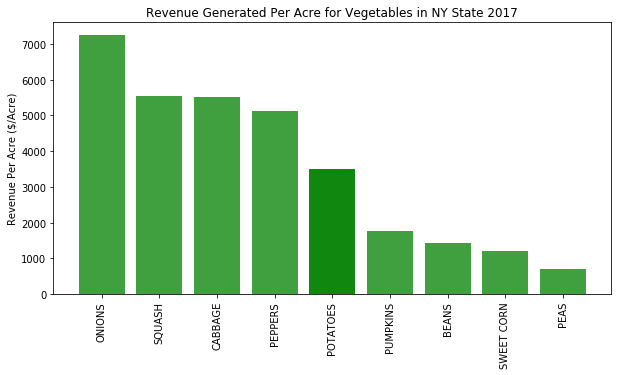

In [6]:
x_axis = ny_veg_fresh_revenue_df['Commodity']
y_axis = ny_veg_fresh_revenue_df['RevenuePerAcre']

#plt.figure(figsize=(10,4))
plt.figure(figsize=(10,5))
plt.bar(x_axis, y_axis, facecolor ='green', alpha=0.75, align ="center")
plt.title("Revenue Generated Per Acre for Vegetables in NY State 2017")
plt.ylabel("Revenue Per Acre ($/Acre)")
plt.xticks(rotation='vertical')
plt.show()
#plt.xlabel()

# Analysis for fruits

In [7]:
fruit_query_url = f"{query_key_url}&sector_desc=CROPS&group_desc__LIKE=FRUIT&agg_level_desc=STATE&state_ansi=36&year=2017&source_desc=SURVEY"

# set up lists to hold reponse info
state_alpha = []
util_practice_desc = []
domain_desc = []
asd_desc = []
freq_desc = []
prodn_practice_desc = []
end_code = []
sector_desc = []
short_desc = []
Value = []
reference_period_desc = []
CV = []
class_desc = []
asd_code = []
domaincat_desc = []
group_desc = []
unit_desc = []
source_desc = []
statisticcat_desc = []
year = []
commodity_desc = []
commodity_desc2 = []

In [8]:
print('Beginning Data Retrieval for fruits')     
print('---------------------------------------')

print(f"query_url is : {fruit_query_url}")
response = requests.get(fruit_query_url).json()
#print(f"response is : {response}")
fruitlist = response['data']

print ("Total fruits found")
print (len(fruitlist))

for fruit in fruitlist:   
    state_alpha.append(fruit['state_alpha'])
    util_practice_desc.append(fruit['util_practice_desc'])
    domain_desc.append(fruit['domain_desc'])
    asd_desc.append(fruit['asd_desc'])
    freq_desc.append(fruit['freq_desc'])
    prodn_practice_desc.append(fruit['prodn_practice_desc'])
    end_code.append(fruit['end_code'])
    sector_desc.append(fruit['sector_desc'])
    short_desc.append(fruit['short_desc'].split("- ")[1])
    commodity_desc2.append(fruit['short_desc'].split(" -")[0])
    Value.append(fruit['Value'])
    reference_period_desc.append(fruit['reference_period_desc'])
    CV.append(fruit['CV (%)'])
    class_desc.append(fruit['class_desc'])
    asd_code.append(fruit['asd_code'])
    domaincat_desc.append(fruit['domaincat_desc'])
    group_desc.append(fruit['group_desc'])
    unit_desc.append(fruit['unit_desc'])
    source_desc.append(fruit['source_desc'])
    statisticcat_desc.append(fruit['statisticcat_desc'])
    year.append(fruit['year'])
    commodity_desc.append(fruit['commodity_desc'])
   
print(f'-----------------------------')
print(f'Data Retrieval Complete     ')
print(f'-----------------------------')

Beginning Data Retrieval for fruits
---------------------------------------
query_url is : https://quickstats.nass.usda.gov/api/api_GET/?key=3FCBDF3D-4566-36B0-8B88-5260E1ACF994&q=&sector_desc=CROPS&group_desc__LIKE=FRUIT&agg_level_desc=STATE&state_ansi=36&year=2017&source_desc=SURVEY
Total fruits found
1265
-----------------------------
Data Retrieval Complete     
-----------------------------


In [9]:
ny_fruit_dict = {
    "Commodity" : commodity_desc,
    "Util":util_practice_desc,
    "Value":Value,
    "Period":reference_period_desc,
    "Group":group_desc,
    "Unit":unit_desc,
    "Short Description":short_desc,
    "State": state_alpha,
    "Year": year
}

ny_fruit_df = pd.DataFrame(ny_fruit_dict)
ny_fruit_df.to_csv('ny_fruit_data.csv')

ny_fruit_df.head()

,Commodity,Util,Value,Period,Group,Unit,Short Description,State,Year
0,APPLES,ALL UTILIZATION PRACTICES,"40,000",YEAR,FRUIT & TREE NUTS,ACRES,ACRES BEARING,NY,2017
1,APPLES,ALL UTILIZATION PRACTICES,20,WEEK #29,FRUIT & TREE NUTS,PCT EXCELLENT,"CONDITION, MEASURED IN PCT EXCELLENT",NY,2017
2,APPLES,ALL UTILIZATION PRACTICES,20,WEEK #30,FRUIT & TREE NUTS,PCT EXCELLENT,"CONDITION, MEASURED IN PCT EXCELLENT",NY,2017
3,APPLES,ALL UTILIZATION PRACTICES,19,WEEK #31,FRUIT & TREE NUTS,PCT EXCELLENT,"CONDITION, MEASURED IN PCT EXCELLENT",NY,2017
4,APPLES,ALL UTILIZATION PRACTICES,21,WEEK #32,FRUIT & TREE NUTS,PCT EXCELLENT,"CONDITION, MEASURED IN PCT EXCELLENT",NY,2017


In [10]:
ny_fruit_acres_df = ny_fruit_df[ ny_fruit_df['Unit'] == "ACRES"]
ny_fruit_acres_df = ny_fruit_acres_df[ ny_fruit_acres_df['Period'] == "YEAR"]
ny_fruit_acres_df = ny_fruit_acres_df[ ny_fruit_acres_df['Short Description'] != "ACRES PLANTED"]
ny_fruit_acres_df = ny_fruit_acres_df.rename(columns={'Unit': 'UnitAcres', 'Util': 'Utilx', 'Value': 'Acres', 'Short Description': 'DescAcres'})
ny_fruit_acres_df['Acres'] = ny_fruit_acres_df['Acres'].str.replace(",","").astype(float)

ny_fruit_production_df = ny_fruit_df[ ny_fruit_df['Period'] == "YEAR"]
ny_fruit_production_df = ny_fruit_production_df[ ny_fruit_production_df['Short Description'] == "PRODUCTION, MEASURED IN $"]
ny_fruit_production_df = ny_fruit_production_df[ ny_fruit_production_df['Util'] != "FRESH MARKET"]
ny_fruit_production_df = ny_fruit_production_df[ ny_fruit_production_df['Util'] != "PROCESSING"]

ny_fruit_production_df = ny_fruit_production_df.rename(columns={'Unit': 'UnitProduction', 'Util': 'Utily','Value': 'ProductionDollars', 'Short Description': 'DescProd'})
ny_fruit_production_df['ProductionDollars'] = ny_fruit_production_df['ProductionDollars'].str.replace(",","").astype(float)


ny_fruit_fresh_revenue_df = pd.merge(ny_fruit_acres_df, ny_fruit_production_df, how="left", 
                                on=["State", "Year", "Commodity","Period","Group"])

ny_fruit_fresh_revenue_df['RevenuePerAcre'] = ny_fruit_fresh_revenue_df['ProductionDollars'] / ny_fruit_fresh_revenue_df['Acres']
ny_fruit_fresh_revenue_df =  ny_fruit_fresh_revenue_df.sort_values(['RevenuePerAcre'], ascending=False)
ny_fruit_fresh_revenue_df = ny_fruit_fresh_revenue_df.round({'RevenuePerAcre' : 2})


ny_fruit_fresh_revenue_df

,Commodity,Utilx,Acres,Period,Group,UnitAcres,DescAcres,State,Year,Utily,ProductionDollars,UnitProduction,DescProd,RevenuePerAcre
5,STRAWBERRIES,ALL UTILIZATION PRACTICES,700.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES HARVESTED,NY,2017,ALL UTILIZATION PRACTICES,6063000.0,$,"PRODUCTION, MEASURED IN $",8661.43
0,APPLES,ALL UTILIZATION PRACTICES,40000.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES BEARING,NY,2017,UTILIZED,343076000.0,$,"PRODUCTION, MEASURED IN $",8576.90
4,PEACHES,ALL UTILIZATION PRACTICES,1600.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES BEARING,NY,2017,UTILIZED,11426000.0,$,"PRODUCTION, MEASURED IN $",7141.25
1,BLUEBERRIES,ALL UTILIZATION PRACTICES,800.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES HARVESTED,NY,2017,UTILIZED,3771000.0,$,"PRODUCTION, MEASURED IN $",4713.75
3,GRAPES,ALL UTILIZATION PRACTICES,35000.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES BEARING,NY,2017,UTILIZED,69078000.0,$,"PRODUCTION, MEASURED IN $",1973.66
2,CHERRIES,ALL UTILIZATION PRACTICES,1400.0,YEAR,FRUIT & TREE NUTS,ACRES,ACRES BEARING,NY,2017,UTILIZED,2436000.0,$,"PRODUCTION, MEASURED IN $",1740.00


# Plot revenue per acre for Fruits in NY

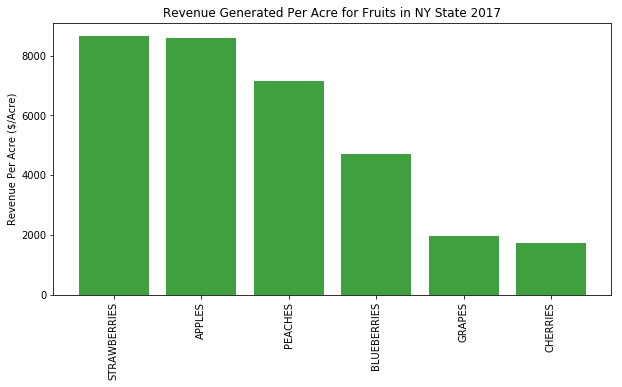

In [11]:
x_axis = ny_fruit_fresh_revenue_df['Commodity']
y_axis = ny_fruit_fresh_revenue_df['RevenuePerAcre']

#plt.figure(figsize=(10,4))
plt.figure(figsize=(10,5))
plt.bar(x_axis, y_axis, facecolor='green', alpha=0.75, align="center")
plt.title("Revenue Generated Per Acre for Fruits in NY State 2017")
plt.ylabel("Revenue Per Acre ($/Acre)")
plt.xticks(rotation='vertical')
plt.show()
#plt.xlabel()